In [118]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from scipy.linalg import svd
import pandas as pd
import seaborn as sns

from pygdsm import GlobalSkyModel2016

import src.forward_model as FM
import src.beam_functions as BF
import src.powerlaw_regression as PR
import src.sky_models as SM
from src.blockmat import BlockMatrix, BlockVector
from src.spherical_harmonics import RealSphericalHarmonics
RS = RealSphericalHarmonics()

In [119]:
# Test out the current code capabilities regarding multifrequency support.
Nfreq = 51
nuarr = np.linspace(50,100,51)
lmax = 32
nside = 16
npix = hp.nside2npix(nside)
narrow_cosbeam = lambda x: BF.beam_cos(x, theta0=0.8)
fg_alm = SM.foreground_gsma_alm(nu=nuarr, lmax=lmax, nside=nside)

mat_A, (mat_G, mat_Y, mat_B) = FM.calc_observation_matrix_all_pix(nside, lmax, Ntau=npix, Nt=npix, beam_use=narrow_cosbeam, return_mat=True)


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


3072 561


In [121]:
# Test on some simple matrices.
m1 = [[1, 2, 3], [4, 5, 6], [7, 8, 9], [1, 2, 3]]
m2 = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
m1 = BlockMatrix(mat=m1, nblock=3)
m2 = BlockMatrix(mat=m2, nblock=3)
m3 = m1@m2
m3.matrix

array([[1., 2., 3., 0., 0., 0., 0., 0., 0.],
       [4., 5., 6., 0., 0., 0., 0., 0., 0.],
       [7., 8., 9., 0., 0., 0., 0., 0., 0.],
       [1., 2., 3., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 2., 3., 0., 0., 0.],
       [0., 0., 0., 4., 5., 6., 0., 0., 0.],
       [0., 0., 0., 7., 8., 9., 0., 0., 0.],
       [0., 0., 0., 1., 2., 3., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 2., 3.],
       [0., 0., 0., 0., 0., 0., 4., 5., 6.],
       [0., 0., 0., 0., 0., 0., 7., 8., 9.],
       [0., 0., 0., 0., 0., 0., 1., 2., 3.]])

In [ ]:
from functools import partial
# Test on a more relevant example.
theta0_arr = np.linspace(0.9, 0.4, 51)
all_beamfunctions = [partial(BF.beam_cos, theta0=theta0) for theta0 in theta0_arr]
all_B_mats = [BF.calc_beam_matrix(nside=nside, lmax=lmax, beam_use=bm) for bm in all_beamfunctions]

fmat_B = BlockMatrix(mat=all_B_mats)
fmat_Y = BlockMatrix(mat=mat_Y, nblock=51)

In [ ]:
fg_alm_vec = BlockVector(vec=fg_alm, nblock=Nfreq)

In [ ]:
vec_Ya = fmat_Y@fg_alm_vec

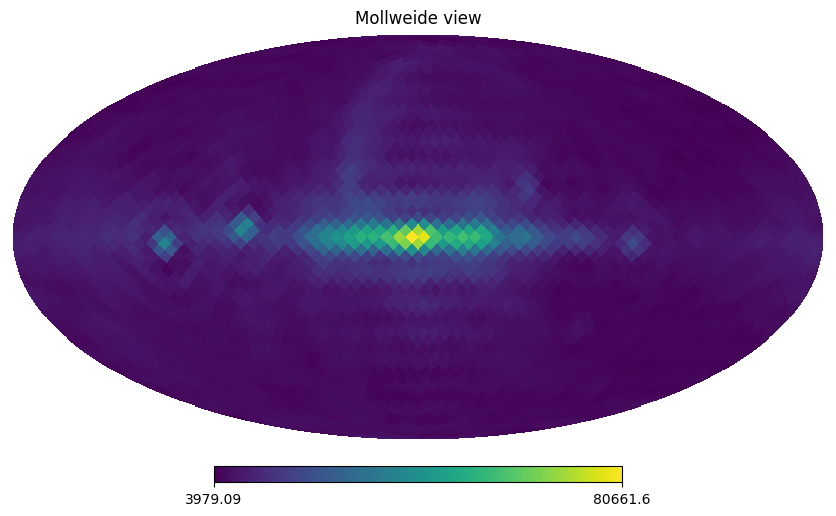

In [ ]:
hp.mollview(vec_Ya.vector_blocks[0])

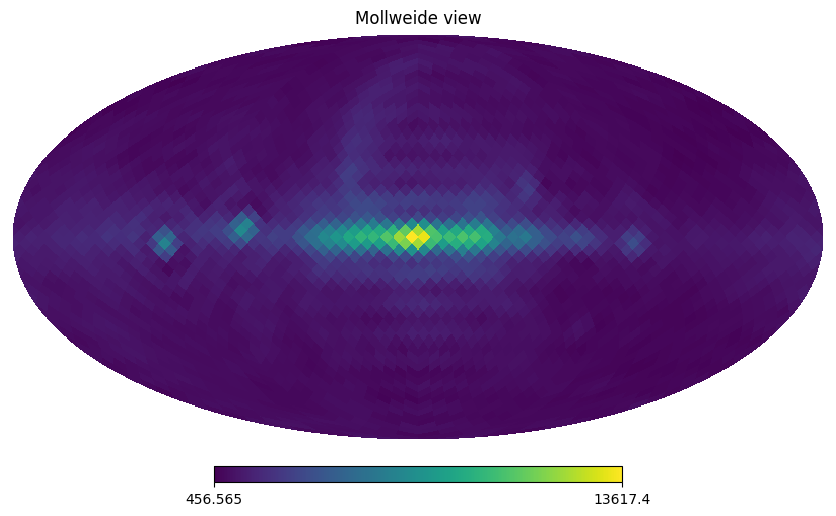

In [ ]:
hp.mollview(vec_Ya.vector_blocks[50])